# Cloud Detection in Landsat 8 Images

In this notebook we will use a UNET CNN architecture to detect cloud and cloud shadows in Landsat 8 Imagery

In [3]:
import os
from pathlib import Path
import rasterio
import xrspatial.multispectral as ms
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from rasterio.windows import Window
from PIL import Image
import h5py

import torch
from torch import nn
import torchvision

In [4]:
class Device:

    def __init__(self, index=0):

        device = f"cuda:{index}"
        # self.gpu = torch.device(device if torch.cuda.is_available() else "cpu")
        # self.gpu = torch.device("cpu")
        self.gpu = torch.device(device)


device = Device(0)
device.gpu

device(type='cuda', index=0)

In [5]:
DATA_ROOT = 'data'
TARGET_ROOT = os.path.join(DATA_ROOT, 'target')
SAMPLE_ROOT = os.path.join(DATA_ROOT, 'samples')
NUM_CLASSES = 7  # https://www.usgs.gov/landsat-missions/spatial-procedures-automated-removal-cloud-and-shadow-sparcs-validation-data

data_root = Path(DATA_ROOT)

target_root = Path(TARGET_ROOT)
if not target_root.exists():
    target_root.mkdir(parents=True)

sample_root = Path(SAMPLE_ROOT)
if not sample_root.exists():
    sample_root.mkdir(parents=True)

ds = xr.open_dataset(r'data\LC81230362013276LGN00_19_data.tif')
ds

ValueError: cannot guess the engine, try passing one explicitly

# Examine some of the samples and their labels

In [6]:

data_files = sorted(list(data_root.glob('*_data.tif')))
quality_files = sorted(list(data_root.glob('*_qmask.tif')))
mask_files = sorted(list(data_root.glob('*_mask.png')))

n_files = 3

for data_file, quality_file, mask_file in zip(data_files[:n_files], quality_files[:n_files], mask_files[:n_files]):
    data = xr.open_dataset(data_file)
    color = ms.true_color(data.sel({'band': 4}).band_data, 
                          data.sel({'band': 3}).band_data, 
                          data.sel({'band': 2}).band_data)    

    extent = color.rio.bounds()
    extent = [extent[0], extent[2], extent[1], extent[3]]

    quality = xr.open_dataset(quality_file)
    quality_plot = quality.sel({'band': 1}).band_data

    mask = xr.open_dataset(mask_file)
    extent = [extent[0], extent[2], extent[1], extent[3]]
    mask_plot = mask.sel({'band': 1}).band_data.values
    fig, ax = plt.subplots(1,3,figsize=(30, 10))
    color.plot.imshow(x='x', y='y', ax=ax[0])
    quality_plot.plot.imshow(x='x', y='y', ax=ax[1], add_colorbar=False)
    ax[2].imshow(mask_plot, extent=extent, cmap='jet')



ValueError: cannot guess the engine, try passing one explicitly

# Prepare samples
Here we cut them into smaller chunks to more easily fit into memory
REMEMBER: I NEED TO GET THE REST OF THE IMAGE USING PADDING

In [35]:
IMG_SIZE = (256,256)
kernel_x, kernel_y = IMG_SIZE

for data_file, mask_file in zip(data_files, mask_files):
    data = xr.open_dataset(data_file)
    mask = rasterio.open(mask_file)
    x_dim, y_dim = data.sel({'band': 2}).band_data.shape

    chunk = 0
    for x1, x2 in zip(np.arange(0, x_dim, kernel_x), np.arange(kernel_x, x_dim, kernel_x)):
        for y1, y2 in zip(np.arange(0, y_dim, kernel_y), np.arange(kernel_y, y_dim, kernel_y)):
            data_chunk = data.isel(x=slice(x1, x2), y=slice(y1,y2)).band_data
            data_chunk.rio.to_raster(os.path.join(str(sample_root.absolute()), data_file.stem + f'_{chunk}.tif'))
                     
            window = Window.from_slices((y1, y2), (x1, x2))
            mask_data = mask.read(1, window=window)
            im = Image.fromarray(mask_data)
            im.save(os.path.join(str(target_root.absolute()), data_file.stem + f'_{chunk}.tif'))
            
            chunk += 1


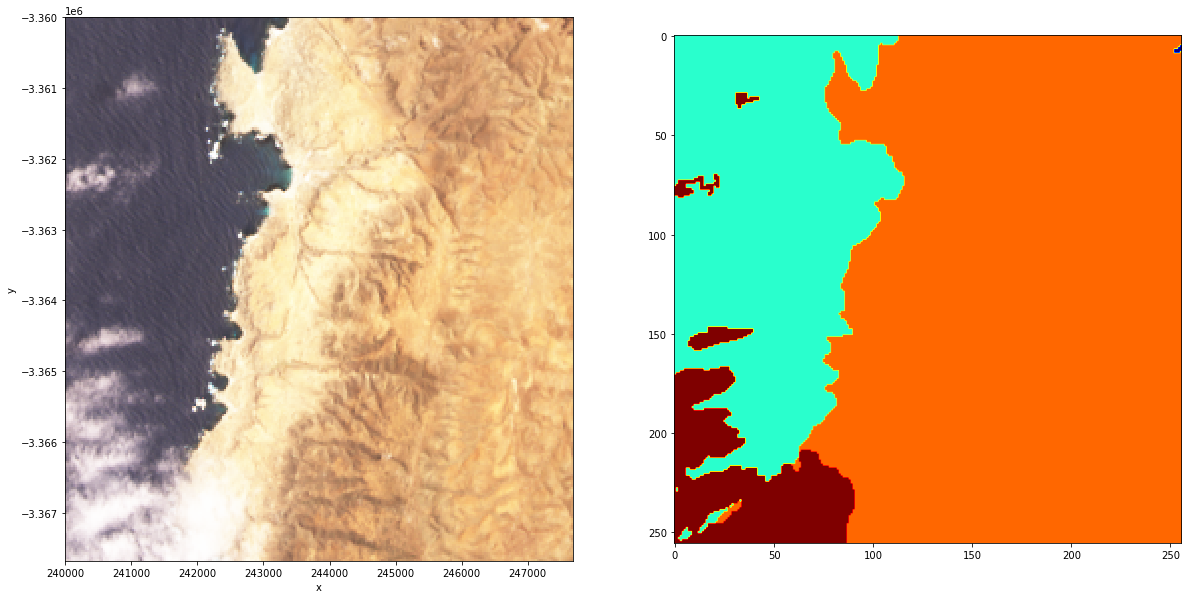

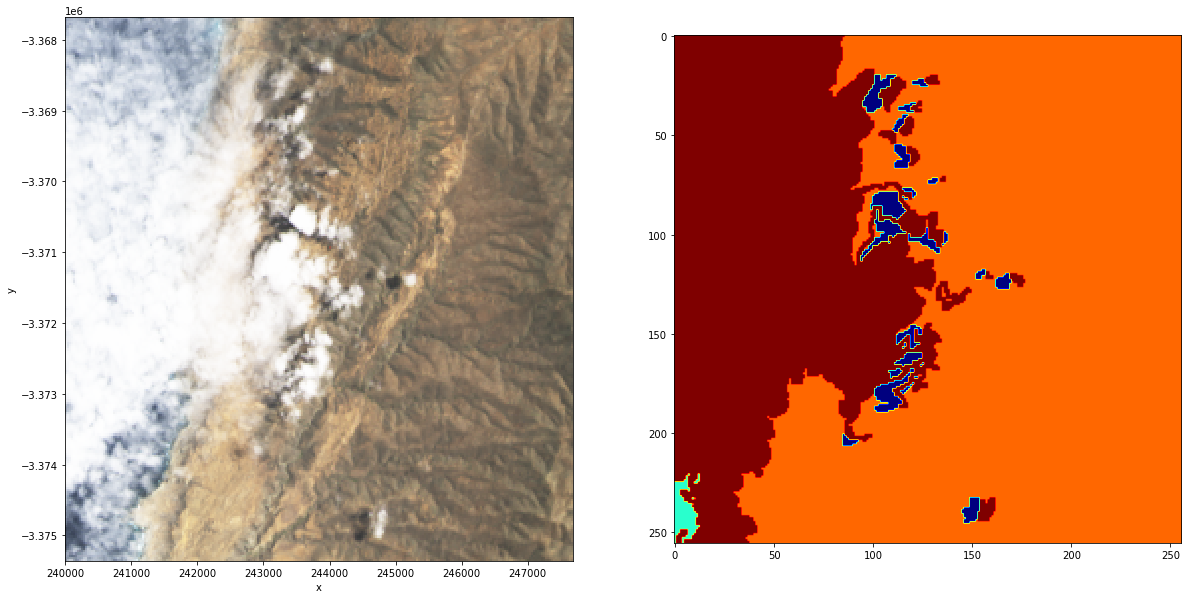

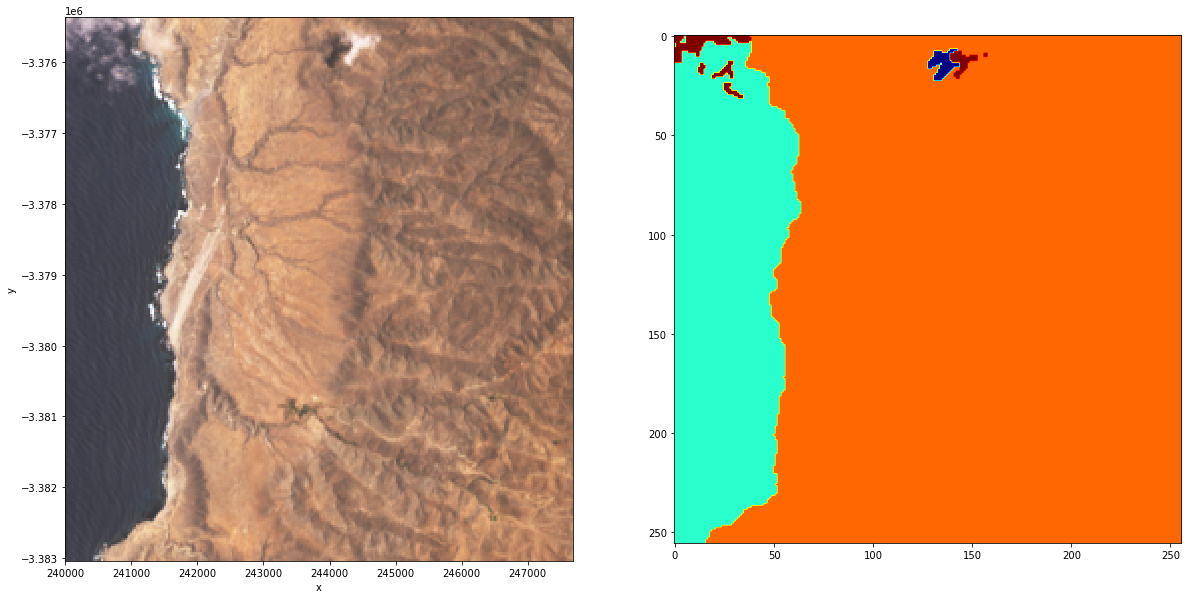

In [36]:
data_files = sorted(list(sample_root.glob('*.tif')))
mask_files = sorted(list(target_root.glob('*.tif')))

n_files = 3

for data_file, mask_file in zip(data_files[:n_files], mask_files[:n_files]):
    data = xr.open_dataset(data_file)
    color = ms.true_color(data.sel({'band': 4}).band_data, 
                          data.sel({'band': 3}).band_data, 
                          data.sel({'band': 2}).band_data)   

    mask = xr.open_dataset(mask_file)
    mask_plot = mask.sel({'band': 1}).band_data.values
    fig, ax = plt.subplots(1,2,figsize=(20, 10))
    color.plot.imshow(x='x', y='y', ax=ax[0])
    ax[1].imshow(mask_plot, cmap='jet')


# Create a data generator

In [110]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, sample_paths, target_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.sample_paths = sample_paths
        self.target_paths = target_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):

        i = idx * self.batch_size
        batch_sample_paths = self.sample_paths[i:i + self.batch_size]
        batch_target_paths = self.target_paths[i:i + self.batch_size]

        X = np.zeros((self.batch_size,) + self.img_size + (10,), dtype="float32")
        for j, path in enumerate(batch_sample_paths):
            dataset = xr.open_dataset(path)
            img = dataset.band_data.values
            img = np.moveaxis(img, [0], [2])
            X[j] = img

        target = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_paths):
            image = Image.open(path)
            image = np.asarray(image)
            image = np.expand_dims(image, 2)
            target[j] = image
            
        return X, target

In [111]:
from sklearn.model_selection import train_test_split


# Split our img paths into a training and a validation set
val_samples = 1000
seed = 42
sample_files = sorted(list(sample_root.glob('*.tif')))
target_files = sorted(list(target_root.glob('*.tif')))

sample_files = [str(file.absolute()) for file in sample_files]
target_files = [str(file.absolute()) for file in target_files]

X_train, X_test, y_train, y_test = train_test_split(sample_files, target_files, test_size=0.2, random_state=42)


# Instantiate data Sequences for each split
BATCH_SIZE=10

train_gen = DataGenerator(BATCH_SIZE, IMG_SIZE, X_train, y_train)
test_gen = DataGenerator(BATCH_SIZE, IMG_SIZE, X_test, y_test)


In [112]:


class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.conv2(self.relu(self.conv1(x)))


class Encoder(nn.Module):
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs


class UNet(nn.Module):
    def __init__(self, enc_chs=(3,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False, out_sz=(572,572)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [113]:
input_shape = (list(IMG_SIZE) + [10])
model = UNet(input_shape)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                0)]                                                               
                                                                                                  
 conv2d_152 (Conv2D)            (None, 256, 256, 64  5824        ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_144 (Batch  (None, 256, 256, 64  256        ['conv2d_152[0][0]']             
 Normalization)                 )                                                           

In [114]:
model.compile(optimizer="ADAM", loss="sparse_categorical_crossentropy")

callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=test_gen, callbacks=callbacks)

Epoch 1/15
 7/57 [==>...........................] - ETA: 7:47 - loss: 1.6819

KeyboardInterrupt: 

In [ ]:
img = load_img(r'd:\projects\cloud-detection\data\target\LC80050152014172LGN00_12_data_6.tif')
dir(img)

['_ArrayData',
 '_Image__transformer',
 '__array__',
 '__class__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_category',
 '_close_exclusive_fp_after_loading',
 '_copy',
 '_crop',
 '_dump',
 '_ensure_mutable',
 '_exif',
 '_expand',
 '_get_safe_box',
 '_getxmp',
 '_new',
 '_repr_png_',
 '_repr_pretty_',
 '_size',
 'alpha_composite',
 'close',
 'convert',
 'copy',
 'crop',
 'draft',
 'effect_spread',
 'entropy',
 'filter',
 'format',
 'format_description',
 'frombytes',
 'getbands',
 'getbbox',
 'getchannel',
 'getcolors',
 'getdata',
 'getexif',
 'getextrema',
 'getim',
 'getpalette',
 'ge

In [65]:
 dataset.band_data.values.shape

(10, 256, 256)

In [88]:
img.size

(256, 256)

In [92]:
np.zeros((10,) + IMG_SIZE + (10,), dtype="float32").shape

(10, 256, 256, 10)

In [97]:
img.resize([img.size[0], img.size[1], -1])

TypeError: argument 1 must be sequence of length 2, not 3

In [103]:
from PIL import Image
image = Image.open(r'd:\projects\cloud-detection\data\target\LC80050152014172LGN00_12_data_6.tif')
image = np.asarray(image)
image = np.expand_dims(image, 2)
image.shape

(256, 256, 1)